In [1]:
#Modified MM

#Importing the Required Libraries

#---import libraries regarding to data manipulation, visualization------------
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json

# Imports Torch Libraries
import torch
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules

#Importing Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score



#Data Loader
import pickle

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
sys.path.append('../../src/')  

#### Import Data Loading and Processing Functions
from multimodal.helper_functions import  reproducible_comp, get_final_df, force_curve_reshape

#### Import Model Architecture
from multimodal.model_architecture import Generic1DCNN

from semi_supervised.augmentations import weak_augment, strong_augment

reproducible_comp()


In [2]:
file_path = "../../data/processed_data/force_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_inner, category_force_inner, category_names, df_force_inner = get_final_df(data, is_acc_data=0, is_multilabel=1)

In [3]:
labels = category_force_inner.copy()
features = features_force_inner.copy()
feat = force_curve_reshape(features)
print("Features Shape: ", feat.shape)
print("Labels Shape: ", labels.shape)

Features Shape:  (1350, 150)
Labels Shape:  (1350, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(feat, labels, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels)

In [5]:
labeled_X, unlabeled_X, labeled_y, unlabeled_y = train_test_split(X_train, y_train, test_size=0.5, 
                                                    random_state=2, shuffle=True, stratify=y_train)

# Splitting Augmented Labeled Dataset into Train and Validation parts
X_labeled, x_val, y_labeled, y_val = train_test_split(labeled_X, labeled_y, random_state=42, test_size=0.20, shuffle=True)


X_labeled = X_labeled.reshape(-1, 1, feat.shape[1])
X_test = X_test.reshape(-1, 1, feat.shape[1])
x_val = x_val.reshape(-1, 1, feat.shape[1])

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled shape:", X_labeled.shape)
print("y_labeled shape:", y_labeled.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

X_unlabeled = unlabeled_X.reshape(-1, 1, feat.shape[1])
y_unlabeled = unlabeled_y.copy()

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled shape:", X_unlabeled.shape)
print("y_labeled shape:", y_unlabeled.shape)

X_labeled shape: (485, 1, 150)
y_labeled shape: (485, 4)
x_val shape: (122, 1, 150)
y_val shape: (122, 4)
X_labeled shape: (608, 1, 150)
y_labeled shape: (608, 4)


In [6]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

# Labeled Data Loader
train_dataset = TensorDataset(torch.tensor(X_labeled, dtype=torch.float), 
                              torch.tensor(y_labeled, dtype=torch.long))

labeled_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation Data loader

valid_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float), 
                              torch.tensor(y_val, dtype=torch.long))

valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size, shuffle=True)

# Strong Unlabeled Data Loader

unlabeled_dataset = TensorDataset(torch.tensor(X_unlabeled, dtype=torch.float), 
                                  torch.tensor(y_unlabeled, dtype=torch.long))
Unlabeled_dataloader= DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)  


In [7]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/force/best_configs/force_inner_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]

input_channels = 1
num_classes = 4
n_layers = best_params["n_layers"]
kernel_size = best_params["kernel_size"]
stride = best_params["stride"]
padding = best_params["padding"]
hidden_channels = best_params["hidden_channels"]
dropout_prob = best_params["dropout_prob"]
pooling_type = best_params["pooling_type"]
use_batch_norm = best_params["use_batch_norm"]
lr = best_params["lr"]
best_params_json = json.dumps(best_params, indent=4)
print(best_params_json)

{
    "lr": 0.006170767628576648,
    "dropout_prob": 0.03377115813672493,
    "hidden_channels": 73,
    "n_layers": 4,
    "kernel_size": 7,
    "stride": 2,
    "padding": 4,
    "pooling_type": "max",
    "use_batch_norm": true
}


In [40]:
def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Generic1DCNN(input_channels, num_classes, n_layers, kernel_size, stride,padding,
                    hidden_channels, dropout_prob, pooling_type, use_batch_norm).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

confidence_threshold = 0.65
lambda_u = 0.5


training_losses = []
validation_losses = []
supervised_losses = []
unsupervised_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_supervised_loss = 0.0
    total_unsupervised_loss = 0.0

    # Supervised training on labeled data
    for inputs, labels in labeled_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_supervised_loss += loss.item()
    
    # Semi-supervised training on unlabeled data
    for inputs_unlabeled, _ in Unlabeled_dataloader:

        inputs_unlabeled = inputs_unlabeled.to(device)

        batch_size = inputs_unlabeled.shape[0]
        
        # Apply weak augmentation
        inputs_weak = weak_augment(inputs_unlabeled, batch_size).float().to(device)
        

        # Generate pseudo-labels
        with torch.no_grad():
            outputs_weak = model(inputs_weak)
            pseudo_probs = torch.softmax(outputs_weak, dim=1)
            max_probs, pseudo_label_indices = torch.max(pseudo_probs, dim=1)
            mask = max_probs.ge(confidence_threshold) 

        # Apply one-hot encoding to the pseudo-label indices
        pseudo_labels_one_hot = torch.nn.functional.one_hot(pseudo_label_indices, num_classes=num_classes)
        pseudo_labels_one_hot = pseudo_labels_one_hot.to(torch.float32)  


        # Apply strong augmentation
        inputs_strong = strong_augment(inputs_unlabeled, batch_size).float().to(device)

        # Calculate unsupervised loss
        optimizer.zero_grad()
        outputs_strong = model(inputs_strong)
        unsupervised_loss = criterion(outputs_strong, pseudo_labels_one_hot)

        unsupervised_loss = torch.mean(unsupervised_loss * mask.float())
        unsupervised_loss_weighted = lambda_u * unsupervised_loss
        unsupervised_loss_weighted.backward()
        optimizer.step()

        running_loss += unsupervised_loss.item()
        total_unsupervised_loss += unsupervised_loss.item()

    # Validation and logging
    model.eval()
    # Validation loss calculation (similar to training loop)
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs_valid, labels_valid in valid_dataloader:
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
            outputs_valid = model(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid.float())
            valid_loss += loss_valid.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / (len(labeled_dataloader) + len(Unlabeled_dataloader))}, Supervised Loss: {total_supervised_loss / len(labeled_dataloader)}, Unsupervised Loss: {total_unsupervised_loss / len(Unlabeled_dataloader)}, Validation Loss: {valid_loss / len(valid_dataloader)}")
    # Inside your training loop, after calculating the losses
    training_losses.append(running_loss / (len(labeled_dataloader) + len(Unlabeled_dataloader)))
    validation_losses.append(valid_loss / len(valid_dataloader))
    supervised_losses.append(total_supervised_loss / len(labeled_dataloader))
    unsupervised_losses.append(total_unsupervised_loss / len(Unlabeled_dataloader))



# Evaluation on the validation set for this fold
model.eval()
y_true_valid = []
y_pred_valid = []

with torch.no_grad():
    for inputs, labels in valid_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.int()
        outputs = model(inputs)
        predicted = (outputs > 0).int()
        y_true_valid.append(labels.cpu().numpy())
        y_pred_valid.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true_valid = np.array(y_true_valid[0]).reshape(-1,4)
y_pred_valid = np.array(y_pred_valid[0]).reshape(-1,4)

accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
print(f"Multi-label Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 10/50, Training Loss: 0.15770188293286733, Supervised Loss: 0.12743248394690454, Unsupervised Loss: 0.18319190313157283, Validation Loss: 0.14564681984484196
Epoch 20/50, Training Loss: 0.10394061670771666, Supervised Loss: 0.07887100439984351, Unsupervised Loss: 0.12505186917750458, Validation Loss: 0.09283861704170704
Epoch 30/50, Training Loss: 0.10432130289929253, Supervised Loss: 0.07414727145805955, Unsupervised Loss: 0.12973101358664663, Validation Loss: 0.11599661037325859
Epoch 40/50, Training Loss: 0.09035752548703126, Supervised Loss: 0.06127007550094277, Unsupervised Loss: 0.1148522202121584, Validation Loss: 0.07495812606066465
Epoch 50/50, Training Loss: 0.09008206363235201, Supervised Loss: 0.05524344835430384, Unsupervised Loss: 0.11941984491912942, Validation Loss: 0.07493932452052832
Multi-label Validation Accuracy: 97.66%


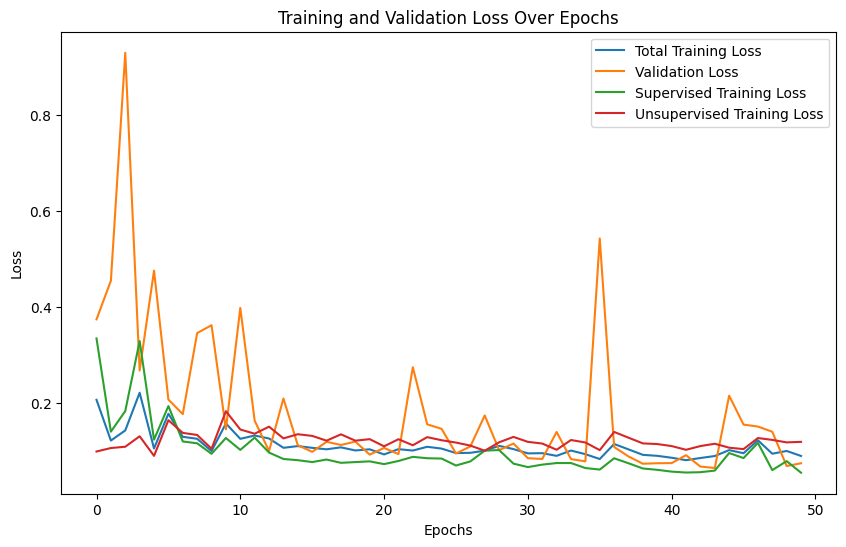

In [41]:
# After training, plot the losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Total Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.plot(supervised_losses, label='Supervised Training Loss')
plt.plot(unsupervised_losses, label='Unsupervised Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [42]:
torch.save(model, '../../artifacts/force_inner_FM.pth')

# Evaluation on test set


In [43]:
model = torch.load('../../artifacts/force_inner_FM.pth')


Multi-label Accuracy: 99.07%
Multi-label F1-Score: 98.79%
Classification Report:
               precision    recall  f1-score   support

        Dünn       1.00      1.00      1.00        52
    Referenz       1.00      1.00      1.00        27
        Slug       1.00      0.91      0.95        54
        Worn       1.00      1.00      1.00        54

   micro avg       1.00      0.97      0.99       187
   macro avg       1.00      0.98      0.99       187
weighted avg       1.00      0.97      0.99       187
 samples avg       1.00      0.98      0.99       187



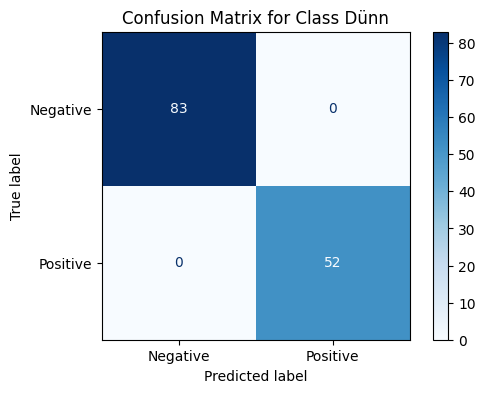

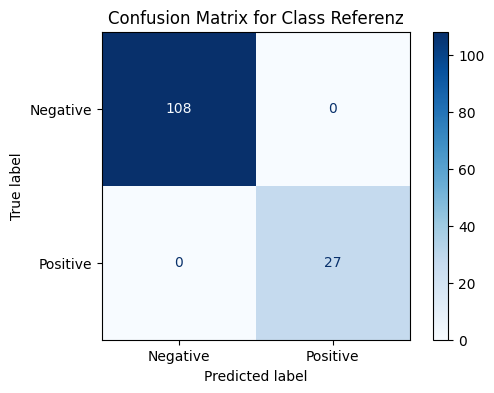

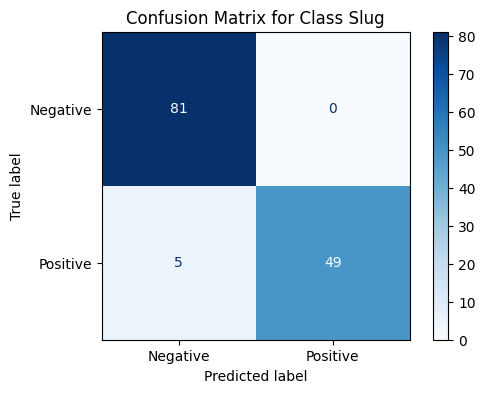

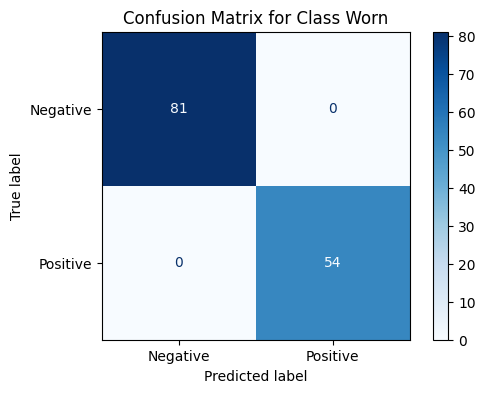

In [44]:
def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

model.eval()

y_true = []
y_pred = []

x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

with torch.no_grad():
    for inputs, labels in zip(x_test, y_test):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Assuming labels are already binary (0 or 1)
        # Remove the argmax and directly use the labels for true values
        labels = labels.int()
        
        outputs = model(inputs.unsqueeze(0))  # Unsqueeze to add a batch dimension
        predicted = (outputs > 0).int()  # Apply threshold (0.5) to convert to 0 or 1
        
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true = np.array(y_true).reshape(-1,4)
y_pred = np.array(y_pred).reshape(-1,4)

accuracy = multi_label_accuracy(y_true, y_pred)
print(f"Multi-label Accuracy: {accuracy * 100:.2f}%")

f1 = f1_score(y_true, y_pred, average='macro')
print(f"Multi-label F1-Score: {f1 * 100:.2f}%")

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=category_names)
print("Classification Report:\n", report)

# Compute the multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_true, y_pred)


# Visualize each confusion matrix with sample counts
for i, matrix in enumerate(conf_matrix):
    total_samples = matrix.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    ax.set_title(f'Confusion Matrix for Class {category_names[i]}')
    
    plt.show()

# Thank You